## 📦 Installazione Pacchetti

Installazione di tutte le librerie necessarie per il progetto.

In [1]:
# Install required packages
# Nota: In VS Code, assicurati di aver selezionato un ambiente Python con Jupyter
import sys
import subprocess

packages = [
    'transformers>=4.30.0',
    'datasets',
    'scikit-learn',
    'seaborn',
    'matplotlib',
    'tqdm',
    'accelerate',
    'sentencepiece',
    'torch',
    'huggingface-hub'
]

print("📦 Installazione pacchetti...")
for package in packages:
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
    except:
        print(f"⚠ Errore nell'installazione di {package}")

print("✅ All packages installed successfully!")

📦 Installazione pacchetti...
✅ All packages installed successfully!


## 🔑 Autenticazione HuggingFace

Configurazione del token HuggingFace.
- **VS Code**: Imposta la variabile d'ambiente `HF_TOKEN`
- **Google Colab**: Usa Colab Secrets

In [2]:
from huggingface_hub import login
import os

# Get HuggingFace token from environment variable
# Per impostare il token: set HF_TOKEN=your_token_here (Windows PowerShell)
# Oppure su Google Colab: userdata.get('HF_TOKEN')
try:
    # Prova prima con variabile d'ambiente (per VS Code)
    HF_TOKEN = os.getenv('HF_TOKEN')

    if HF_TOKEN is None:
        # Fallback per Google Colab
        try:
            from google.colab import userdata
            HF_TOKEN = userdata.get('HF_TOKEN')
        except:
            print("⚠ HF_TOKEN non trovato. Puoi impostarlo con:")
            print("  - Windows: $env:HF_TOKEN='your_token'")
            print("  - Linux/Mac: export HF_TOKEN='your_token'")
            print("  - Google Colab: Aggiungi HF_TOKEN ai Secrets")
            HF_TOKEN = None

    if HF_TOKEN:
        # Login to HuggingFace
        login(token=HF_TOKEN)
        print("✅ Successfully authenticated with HuggingFace!")
    else:
        print("⚠ Continuando senza autenticazione HuggingFace.")
        print("  Alcuni modelli potrebbero non essere accessibili.")

except Exception as e:
    print(f"⚠ Errore durante l'autenticazione: {e}")
    print("  Continuando senza autenticazione HuggingFace.")

✅ Successfully authenticated with HuggingFace!


## ⚙️ Configurazione Dataset

Configurazione degli URL per il caricamento dei dati da GitHub.

In [ ]:
# Configuration
TRACK = "track_a"
SUBTASK = "3"  # Subtask 3 per Quadruplet Extraction (DimASQP)
LANGUAGE = "eng"  # Lingua: eng, jpn, rus, tat, ukr, zho
DOMAIN = "restaurant"  # Dominio: restaurant, laptop, hotel

# Build GitHub URLs
BASE_URL = "https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset"
TRAIN_URL = f"{BASE_URL}/{TRACK}/subtask_{SUBTASK}/{LANGUAGE}/{LANGUAGE}_{DOMAIN}_train_alltasks.jsonl"

# Display configuration
print("="*60)
print("📊 CONFIGURAZIONE DATASET")
print("="*60)
print(f"Track:     {TRACK}")
print(f"Subtask:   {SUBTASK} (Quadruplet Extraction - DimASQP)")
print(f"Language:  {LANGUAGE}")
print(f"Domain:    {DOMAIN}")
print(f"\nTrain URL: {TRAIN_URL}")
print("="*60)

📊 CONFIGURAZIONE DATASET
Track:     track_a
Subtask:   2 (Triplet Extraction)
Language:  eng
Domain:    restaurant

Train URL: https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset/track_a/subtask_2/eng/eng_restaurant_train_alltasks.jsonl


# DimABSA Track A - Subtask 3: Dimensional Aspect Sentiment Quad Prediction (DimASQP)

## Obiettivo
Dato un testo, estrarre tutti i **quadruplet (Aspect, Category, Opinion, VA)** dove:
- **Aspect**: termine che indica l'aspetto target (può essere NULL)
- **Category**: categoria dell'aspetto nel formato ENTITY#ATTRIBUTE (NON è mai NULL, sempre UPPERCASE)
- **Opinion**: termine che esprime il sentiment (può essere NULL)
- **VA**: punteggio Valence-Arousal (V#A) con valori da 1.00 a 9.00

## Pipeline
1. **Estrazione Aspect/Category/Opinion**: Uso di LLM (LLAMA) con prompt engineering
2. **Predizione VA**: Modello encoder (BERT multilingua) per predire i valori continui

---

## 1. Setup e Import Librerie

In [4]:
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    BitsAndBytesConfig,
    pipeline,
    AutoModel
)

# PyTorch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Set seed per riproducibilità
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 2. Analisi del Dataset

In [5]:
def load_jsonl_from_url(url: str) -> List[Dict]:
    """
    Carica dati JSONL da un URL GitHub.

    Args:
        url: URL del file JSONL

    Returns:
        Lista di dizionari
    """
    import urllib.request

    try:
        print(f"⏳ Caricamento da {url.split('/')[-1]}...")
        with urllib.request.urlopen(url) as response:
            data = response.read().decode('utf-8')
            items = [json.loads(line) for line in data.strip().split('\n') if line.strip()]
        print(f"✓ Caricati {len(items)} esempi")
        return items
    except Exception as e:
        print(f"❌ Errore nel caricamento da {url}: {e}")
        raise

# Caricamento dati
train_data = load_jsonl_from_url(TRAIN_URL)
print(f"\n{'='*60}")
print(f"DATASET CARICATO")
print(f"{'='*60}")
print(f"Numero di esempi nel training set: {len(train_data)}")
print(f"\nEsempio di dato:")
print(json.dumps(train_data[0], indent=2))


⏳ Caricamento da eng_restaurant_train_alltasks.jsonl...
✓ Caricati 2284 esempi

DATASET CARICATO
Numero di esempi nel training set: 2284

Esempio di dato:
{
  "ID": "rest16_quad_dev_1",
  "Text": "ca n ' t wait wait for my next visit .",
  "Quadruplet": [
    {
      "Aspect": "NULL",
      "Opinion": "NULL",
      "Category": "RESTAURANT#GENERAL",
      "VA": "6.75#6.38"
    }
  ]
}


In [ ]:
# Analisi statistica del dataset
def analyze_dataset(data: List[Dict]) -> Dict:
    """Analizza il dataset e restituisce statistiche."""
    stats = {
        'valence_values': [],
        'arousal_values': [],
        'text_lengths': [],
        'num_triplets': [],
        'aspects': [],
        'opinions': [],
        'categories': [],
        'null_aspect_count': 0,
        'null_opinion_count': 0,
        'null_both_count': 0
    }

    for item in data:
        text_length = len(item['Text'].split())
        stats['text_lengths'].append(text_length)

        quadruplets = item.get('Quadruplet', item.get('Triplet', []))
        stats['num_triplets'].append(len(quadruplets))

        for quad in quadruplets:
            va = quad['VA'].split('#')
            stats['valence_values'].append(float(va[0]))
            stats['arousal_values'].append(float(va[1]))
            
            # Analisi Aspect, Opinion, Category
            aspect = quad['Aspect']
            opinion = quad['Opinion']
            category = quad.get('Category', 'N/A')
            
            stats['aspects'].append(aspect)
            stats['opinions'].append(opinion)
            stats['categories'].append(category)
            
            # Conta NULL
            if aspect == 'NULL' and opinion == 'NULL':
                stats['null_both_count'] += 1
            elif aspect == 'NULL':
                stats['null_aspect_count'] += 1
            elif opinion == 'NULL':
                stats['null_opinion_count'] += 1

    return stats

# Calcola statistiche
train_stats = analyze_dataset(train_data)

print(f"\n{'='*60}")
print("STATISTICHE DATASET")
print(f"{'='*60}")
print(f"Numero totale di quadruplet: {len(train_stats['valence_values'])}")
print(f"\nValence:")
print(f"  - Media: {np.mean(train_stats['valence_values']):.2f}")
print(f"  - Std: {np.std(train_stats['valence_values']):.2f}")
print(f"  - Min: {np.min(train_stats['valence_values']):.2f}")
print(f"  - Max: {np.max(train_stats['valence_values']):.2f}")
print(f"\nArousal:")
print(f"  - Media: {np.mean(train_stats['arousal_values']):.2f}")
print(f"  - Std: {np.std(train_stats['arousal_values']):.2f}")
print(f"  - Min: {np.min(train_stats['arousal_values']):.2f}")
print(f"  - Max: {np.max(train_stats['arousal_values']):.2f}")
print(f"\nLunghezza testi:")
print(f"  - Media: {np.mean(train_stats['text_lengths']):.1f} parole")
print(f"  - Min: {np.min(train_stats['text_lengths'])} parole")
print(f"  - Max: {np.max(train_stats['text_lengths'])} parole")
print(f"\nNull Values:")
print(f"  - Aspect NULL (Opinion presente): {train_stats['null_aspect_count']}")
print(f"  - Opinion NULL (Aspect presente): {train_stats['null_opinion_count']}")
print(f"  - Entrambi NULL: {train_stats['null_both_count']}")
print(f"  - Categorie uniche: {len(set(train_stats['categories']))}")
print(f"{'='*60}")


STATISTICHE DATASET
Numero totale di triplet: 3659

Valence:
  - Media: 6.22
  - Std: 1.83
  - Min: 1.00
  - Max: 9.00

Arousal:
  - Media: 6.84
  - Std: 1.13
  - Min: 3.83
  - Max: 9.00

Lunghezza testi:
  - Media: 15.1 parole
  - Min: 1 parole
  - Max: 84 parole


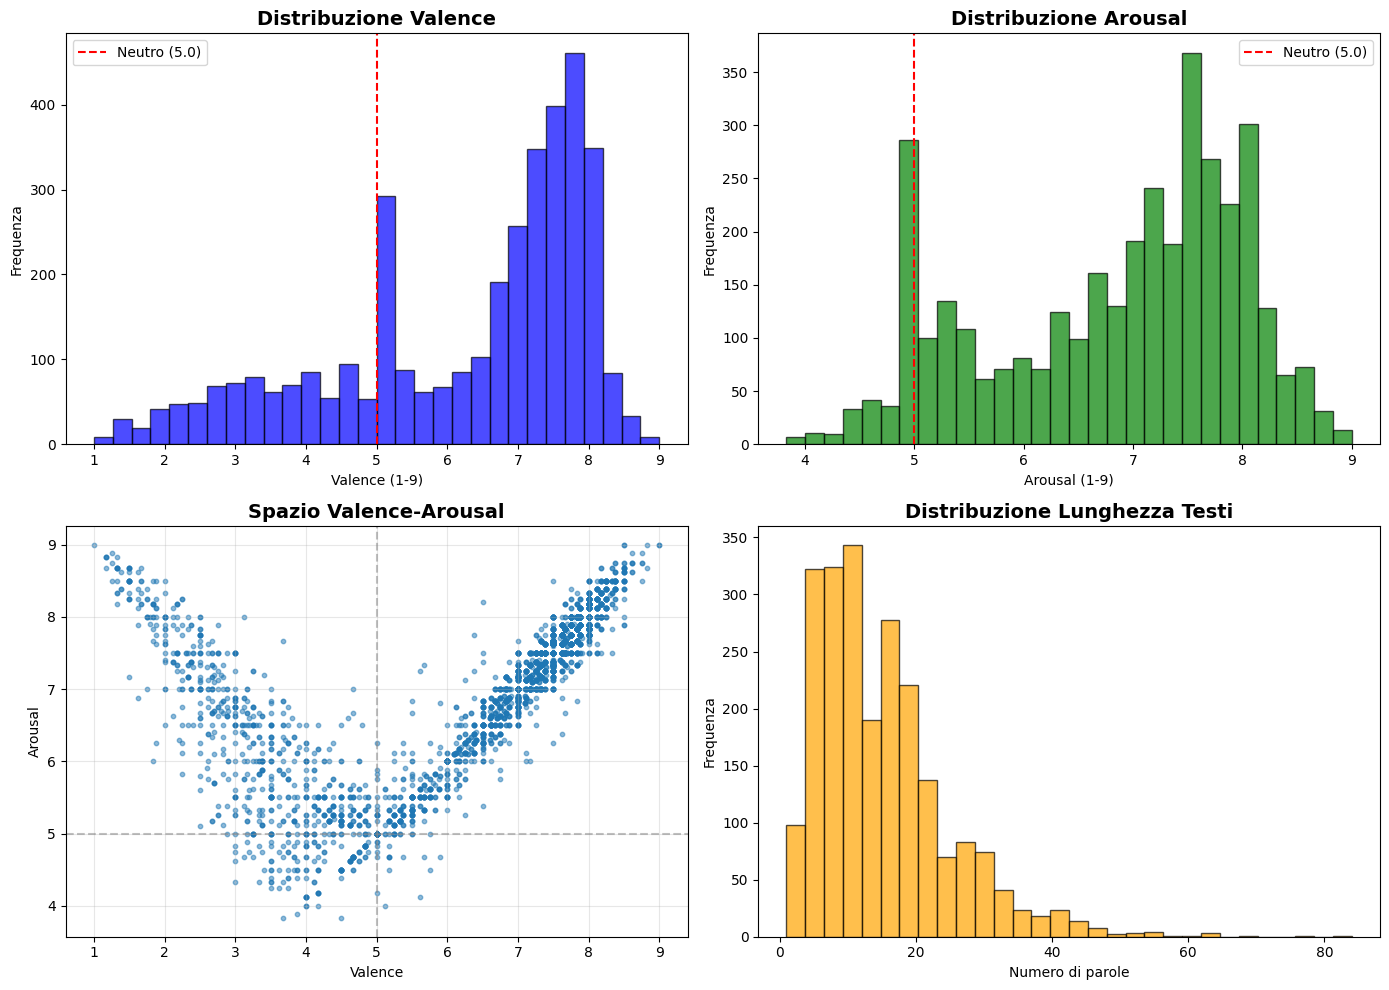

In [7]:
# Visualizzazioni
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribuzione Valence
axes[0, 0].hist(train_stats['valence_values'], bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribuzione Valence', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Valence (1-9)')
axes[0, 0].set_ylabel('Frequenza')
axes[0, 0].axvline(5.0, color='red', linestyle='--', label='Neutro (5.0)')
axes[0, 0].legend()

# Distribuzione Arousal
axes[0, 1].hist(train_stats['arousal_values'], bins=30, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribuzione Arousal', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Arousal (1-9)')
axes[0, 1].set_ylabel('Frequenza')
axes[0, 1].axvline(5.0, color='red', linestyle='--', label='Neutro (5.0)')
axes[0, 1].legend()

# Scatter plot VA
axes[1, 0].scatter(train_stats['valence_values'], train_stats['arousal_values'],
                   alpha=0.5, s=10)
axes[1, 0].set_title('Spazio Valence-Arousal', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Valence')
axes[1, 0].set_ylabel('Arousal')
axes[1, 0].axhline(5.0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].axvline(5.0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# Distribuzione lunghezza testi
axes[1, 1].hist(train_stats['text_lengths'], bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Distribuzione Lunghezza Testi', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Numero di parole')
axes[1, 1].set_ylabel('Frequenza')

plt.tight_layout()
plt.show()

In [ ]:
# Grafici avanzati per Aspect, Opinion e Category
from collections import Counter

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Top 15 Aspect più frequenti (escludendo NULL)
aspect_counts = Counter([a for a in train_stats['aspects'] if a != 'NULL'])
top_aspects = aspect_counts.most_common(15)
aspects_labels = [a[0] for a in top_aspects]
aspects_values = [a[1] for a in top_aspects]

axes[0, 0].barh(range(len(aspects_labels)), aspects_values, color='steelblue', edgecolor='black')
axes[0, 0].set_yticks(range(len(aspects_labels)))
axes[0, 0].set_yticklabels(aspects_labels, fontsize=9)
axes[0, 0].set_title('Top 15 Aspect più Frequenti', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Frequenza')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Top 15 Opinion più frequenti (escludendo NULL)
opinion_counts = Counter([o for o in train_stats['opinions'] if o != 'NULL'])
top_opinions = opinion_counts.most_common(15)
opinions_labels = [o[0] for o in top_opinions]
opinions_values = [o[1] for o in top_opinions]

axes[0, 1].barh(range(len(opinions_labels)), opinions_values, color='coral', edgecolor='black')
axes[0, 1].set_yticks(range(len(opinions_labels)))
axes[0, 1].set_yticklabels(opinions_labels, fontsize=9)
axes[0, 1].set_title('Top 15 Opinion più Frequenti', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Frequenza')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Distribuzione Category
category_counts = Counter(train_stats['categories'])
categories_sorted = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
cat_labels = [c[0] for c in categories_sorted]
cat_values = [c[1] for c in categories_sorted]

axes[0, 2].barh(range(len(cat_labels)), cat_values, color='mediumseagreen', edgecolor='black')
axes[0, 2].set_yticks(range(len(cat_labels)))
axes[0, 2].set_yticklabels(cat_labels, fontsize=8)
axes[0, 2].set_title('Distribuzione Category (ENTITY#ATTRIBUTE)', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Frequenza')
axes[0, 2].invert_yaxis()
axes[0, 2].grid(axis='x', alpha=0.3)

# 4. Distribuzione NULL values
null_categories = ['Aspect NULL\n(Opinion presente)', 'Opinion NULL\n(Aspect presente)', 'Entrambi NULL']
null_values = [train_stats['null_aspect_count'], train_stats['null_opinion_count'], train_stats['null_both_count']]
colors_null = ['#ff7f0e', '#2ca02c', '#d62728']

axes[1, 0].bar(null_categories, null_values, color=colors_null, edgecolor='black', alpha=0.8)
axes[1, 0].set_title('Distribuzione Valori NULL', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Frequenza')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(null_values):
    axes[1, 0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# 5. Lunghezza Aspect (escludendo NULL)
aspect_lengths = [len(a.split()) for a in train_stats['aspects'] if a != 'NULL']
axes[1, 1].hist(aspect_lengths, bins=range(1, max(aspect_lengths)+2), color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribuzione Lunghezza Aspect (parole)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Numero di parole')
axes[1, 1].set_ylabel('Frequenza')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].axvline(np.mean(aspect_lengths), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(aspect_lengths):.1f}')
axes[1, 1].legend()

# 6. Lunghezza Opinion (escludendo NULL)
opinion_lengths = [len(o.split()) for o in train_stats['opinions'] if o != 'NULL']
axes[1, 2].hist(opinion_lengths, bins=range(1, max(opinion_lengths)+2), color='lightcoral', edgecolor='black', alpha=0.7)
axes[1, 2].set_title('Distribuzione Lunghezza Opinion (parole)', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Numero di parole')
axes[1, 2].set_ylabel('Frequenza')
axes[1, 2].grid(axis='y', alpha=0.3)
axes[1, 2].axvline(np.mean(opinion_lengths), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(opinion_lengths):.1f}')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Insights:")
print(f"  - Aspect più comune: '{top_aspects[0][0]}' ({top_aspects[0][1]} occorrenze)")
print(f"  - Opinion più comune: '{top_opinions[0][0]}' ({top_opinions[0][1]} occorrenze)")
print(f"  - Category più comune: '{categories_sorted[0][0]}' ({categories_sorted[0][1]} occorrenze)")
print(f"  - Lunghezza media Aspect: {np.mean(aspect_lengths):.2f} parole")
print(f"  - Lunghezza media Opinion: {np.mean(opinion_lengths):.2f} parole")

In [ ]:
# Per Subtask 3, i dati sono già in formato Quadruplet, non serve conversione
print(f"Dati in formato Quadruplet per Subtask 3")
print(f"\nEsempio di Quadruplet dal dataset:")
print(json.dumps(train_data[2], indent=2))

Dati convertiti in formato Triplet

Esempio dopo conversione:
{
  "ID": "rest16_quad_dev_3",
  "Text": "the spicy tuna roll was unusually good and the rock shrimp tempura was awesome , great appetizer to share !",
  "Triplet": [
    {
      "Aspect": "spicy tuna roll",
      "Opinion": "unusually good",
      "VA": "7.50#7.62"
    },
    {
      "Aspect": "rock shrimp tempura",
      "Opinion": "awesome",
      "VA": "8.25#8.38"
    }
  ]
}


In [ ]:
@dataclass
class QuadrupletExample:
    """Classe per rappresentare un esempio di quadruplet."""
    id: str
    text: str
    quadruplets: List[Dict[str, str]]

class DimABSADataset(Dataset):
    """Dataset personalizzato per DimABSA Subtask 3."""

    def __init__(self, data: List[Dict]):
        self.examples = []

        for item in data:
            example = QuadrupletExample(
                id=item['ID'],
                text=item['Text'],
                quadruplets=item['Quadruplet']
            )
            self.examples.append(example)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]

# Creazione dataset
train_dataset = DimABSADataset(train_data)
print(f"\nDataset creato con {len(train_dataset)} esempi")
print(f"\nEsempio dal dataset:")
example = train_dataset[2]
print(f"ID: {example.id}")
print(f"Text: {example.text}")
print(f"Quadruplets: {example.quadruplets}")


Dataset creato con 2284 esempi

Esempio dal dataset:
ID: rest16_quad_dev_3
Text: the spicy tuna roll was unusually good and the rock shrimp tempura was awesome , great appetizer to share !
Triplets: [{'Aspect': 'spicy tuna roll', 'Opinion': 'unusually good', 'VA': '7.50#7.62'}, {'Aspect': 'rock shrimp tempura', 'Opinion': 'awesome', 'VA': '8.25#8.38'}]


In [ ]:
class AspectOpinionCategoryExtractor:
    """Estrattore di Aspect, Opinion e Category usando LLM per Subtask 3."""

    def __init__(self, model_name: str = "meta-llama/Llama-3.2-3B-Instruct"):
        """
        Inizializza l'estrattore.

        Args:
            model_name: Nome del modello HuggingFace da utilizzare
        """
        print(f"Caricamento del modello {model_name}...")

        # Carica tokenizer e modello (senza quantizzazione)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,  # Usa float16 per efficienza
            device_map="auto",
            trust_remote_code=True
        )

        # Set pad token
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        print("Modello caricato con successo!")

    def create_prompt(self, text: str) -> str:
        """Crea il prompt few-shot per l'estrazione di Aspect, Opinion e Category."""
        prompt = f"""You are an aspect-category-opinion extraction system for restaurant reviews. Extract quadruplets and return ONLY a valid JSON array.

RULES:
1. ASPECT = target entity/attribute (e.g., "food", "service"). Use "NULL" if implicit or not mentioned.
2. CATEGORY = Entity#Attribute in UPPERCASE (e.g., "FOOD#QUALITY", "SERVICE#GENERAL"). NEVER NULL - always predict a category.
3. OPINION = sentiment word (e.g., "delicious", "terrible"). Use "NULL" if implicit or not expressed.
4. Return ONLY the JSON array, nothing else.

VALID CATEGORIES for Restaurant domain:
- Entities: RESTAURANT, FOOD, DRINKS, AMBIENCE, SERVICE, LOCATION
- Attributes: GENERAL, PRICES, QUALITY, STYLE_OPTIONS, MISCELLANEOUS
- Format: ENTITY#ATTRIBUTE (e.g., FOOD#QUALITY, SERVICE#GENERAL, RESTAURANT#PRICES)

EXAMPLES (including NULL cases):

Text: "The food was delicious but the service was slow."
[{{"aspect": "food", "category": "FOOD#QUALITY", "opinion": "delicious"}}, {{"aspect": "service", "category": "SERVICE#GENERAL", "opinion": "slow"}}]

Text: "Great atmosphere and amazing cocktails!"
[{{"aspect": "atmosphere", "category": "AMBIENCE#GENERAL", "opinion": "Great"}}, {{"aspect": "cocktails", "category": "DRINKS#QUALITY", "opinion": "amazing"}}]

Text: "It was horrible."
[{{"aspect": "NULL", "category": "RESTAURANT#GENERAL", "opinion": "horrible"}}]

Text: "Get the tuna of gari."
[{{"aspect": "tuna of gari", "category": "FOOD#QUALITY", "opinion": "NULL"}}]

Text: "The food here is rather good, but only if you like to wait for it."
[{{"aspect": "food", "category": "FOOD#QUALITY", "opinion": "rather good"}}, {{"aspect": "NULL", "category": "SERVICE#GENERAL", "opinion": "NULL"}}]

Text: "We will return many times."
[{{"aspect": "NULL", "category": "RESTAURANT#GENERAL", "opinion": "NULL"}}]

Text: "{text}"
"""
        return prompt

    def extract(self, text: str, max_new_tokens: int = 200) -> List[Dict[str, str]]:
        """Estrae aspect, category e opinion dal testo con parsing JSON robusto."""
        prompt = self.create_prompt(text)

        # Tokenizza
        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

        # Genera
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        # Decodifica SOLO la parte generata (non il prompt)
        generated_ids = outputs[0][inputs['input_ids'].shape[1]:]
        response = self.tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

        # PARSING JSON MIGLIORATO
        try:
            # Step 1: Rimuovi markdown code blocks
            response = response.replace('```json', '').replace('```', '').strip()

            # Step 2: Trova il primo array JSON completo
            import re

            # Cerca l'inizio di un array JSON
            start_idx = response.find('[')
            if start_idx == -1:
                # Nessun array trovato - default con categoria RESTAURANT#GENERAL
                return [{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}]

            # Conta le parentesi per trovare l'array completo
            bracket_count = 0
            end_idx = -1
            in_string = False
            escape_next = False

            for i in range(start_idx, len(response)):
                char = response[i]

                # Gestione escape
                if escape_next:
                    escape_next = False
                    continue
                if char == '\\':
                    escape_next = True
                    continue

                # Gestione stringhe
                if char == '"':
                    in_string = not in_string
                    continue

                # Conta parentesi solo fuori dalle stringhe
                if not in_string:
                    if char == '[':
                        bracket_count += 1
                    elif char == ']':
                        bracket_count -= 1
                        if bracket_count == 0:
                            end_idx = i + 1
                            break

            if end_idx == -1:
                # Array non chiuso, prova con regex
                match = re.search(r'\[[\s\S]*?\]', response)
                if match:
                    json_str = match.group(0)
                else:
                    return [{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}]
            else:
                json_str = response[start_idx:end_idx]

            # Step 3: Parse JSON
            result = json.loads(json_str)

            # Step 4: Normalizza e valida
            if isinstance(result, list) and len(result) > 0:
                normalized = []
                for item in result:
                    if isinstance(item, dict):
                        aspect = str(item.get('aspect', item.get('Aspect', 'NULL'))).strip()
                        category = str(item.get('category', item.get('Category', 'RESTAURANT#GENERAL'))).strip().upper()
                        opinion = str(item.get('opinion', item.get('Opinion', 'NULL'))).strip()

                        # Valida che non siano vuoti
                        if not aspect:
                            aspect = 'NULL'
                        if not opinion:
                            opinion = 'NULL'
                        # Category NON può essere NULL - usa default se mancante
                        if not category or category == 'NULL':
                            category = 'RESTAURANT#GENERAL'

                        normalized.append({
                            'Aspect': aspect,
                            'Category': category,
                            'Opinion': opinion
                        })

                return normalized if normalized else [{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}]
            else:
                return [{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}]

        except json.JSONDecodeError as e:
            print(f"⚠ JSON parsing error: {e}")
            print(f"  Generated text: {response[:150]}...")
            return [{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}]
        except Exception as e:
            print(f"⚠ Extraction error: {e}")
            print(f"  Generated text: {response[:150]}...")
            return [{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}]

print("\nNOTA: L'estrazione con LLM richiede una GPU con almeno 6GB di VRAM per Llama-3.2-3B.")
print("Assicurati di aver configurato il token HuggingFace nella cella iniziale.")


NOTA: L'estrazione con LLM richiede una GPU con almeno 6GB di VRAM per Llama-3.2-3B.
Assicurati di aver configurato il token HuggingFace nella cella iniziale.


## 🔍 Debug: Output Grezzo del Modello LLAMA

Visualizziamo l'output effettivo del modello LLAMA prima del parsing JSON per capire cosa sta generando.

In [ ]:
def debug_llm_output(extractor: AspectOpinionCategoryExtractor, text: str, max_new_tokens: int = 200):
    """
    Mostra l'output grezzo del modello LLAMA prima del parsing.
    
    Args:
        extractor: AspectOpinionCategoryExtractor
        text: Testo di input
        max_new_tokens: Numero massimo di token da generare
    """
    print(f"{'='*80}")
    print(f"📝 TESTO DI INPUT")
    print(f"{'='*80}")
    print(f"{text}")
    print()
    
    # Crea il prompt
    prompt = extractor.create_prompt(text)
    
    print(f"{'='*80}")
    print(f"📋 PROMPT INVIATO AL MODELLO")
    print(f"{'='*80}")
    print(f"{prompt}")
    print()
    
    # Tokenizza
    inputs = extractor.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048)
    inputs = {k: v.to(extractor.model.device) for k, v in inputs.items()}
    
    # Genera
    with torch.no_grad():
        outputs = extractor.model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=extractor.tokenizer.pad_token_id,
            eos_token_id=extractor.tokenizer.eos_token_id
        )
    
    # Decodifica SOLO la parte generata
    generated_ids = outputs[0][inputs['input_ids'].shape[1]:]
    raw_output = extractor.tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
    
    print(f"{'='*80}")
    print(f"🤖 OUTPUT GREZZO DEL MODELLO LLAMA (prima del parsing)")
    print(f"{'='*80}")
    print(f"{raw_output}")
    print()
    
    # Mostra anche il risultato dopo il parsing
    print(f"{'='*80}")
    print(f"✅ RISULTATO DOPO IL PARSING JSON")
    print(f"{'='*80}")
    parsed_result = extractor.extract(text, max_new_tokens=max_new_tokens)
    print(json.dumps(parsed_result, indent=2, ensure_ascii=False))
    print(f"{'='*80}")
    
    return raw_output, parsed_result


# Test con alcuni esempi dal training set
print("\n🧪 TEST DELL'OUTPUT GREZZO DEL MODELLO LLAMA\n")

# Crea l'extractor (se non già creato)
try:
    # Verifica se llm_extractor esiste già
    llm_extractor
    print("✓ LLM Extractor già caricato\n")
except NameError:
    print("⏳ Caricamento LLM Extractor...\n")
    llm_extractor = AspectOpinionCategoryExtractor(model_name="meta-llama/Llama-3.2-3B-Instruct")
    print("✓ LLM Extractor caricato\n")

# Test su 3 esempi diversi
test_examples = [
    "ca n ' t wait wait for my next visit .",
    "Great atmosphere and amazing cocktails!",
    "It was horrible."
]

for i, text in enumerate(test_examples, 1):
    print(f"\n{'#'*80}")
    print(f"ESEMPIO {i}/{len(test_examples)}")
    print(f"{'#'*80}\n")
    raw, parsed = debug_llm_output(llm_extractor, text)
    print("\n")


In [ ]:
class VADataset(Dataset):
    """Dataset per il training del modello VA (Subtask 3 con Category)."""

    def __init__(self, data: List[Dict], tokenizer, max_length: int = 128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Prepara gli esempi
        self.examples = []
        for item in data:
            text = item['Text']
            for quadruplet in item['Quadruplet']:
                aspect = quadruplet['Aspect']
                category = quadruplet['Category']
                opinion = quadruplet['Opinion']
                va = quadruplet['VA'].split('#')
                valence = float(va[0])
                arousal = float(va[1])

                # Salva direttamente text, aspect, category e opinion separatamente
                self.examples.append({
                    'text': text,
                    'aspect': aspect,
                    'category': category,
                    'opinion': opinion,
                    'valence': valence,
                    'arousal': arousal
                })

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]

        # Estrai direttamente i valori dal dizionario
        text = example['text']
        aspect = example['aspect']
        category = example['category']
        opinion = example['opinion']

        # Tokenizza con formato BERT a due segmenti:
        # [CLS] aspect: X; category: Y; opinion: Z [SEP] text [SEP]
        # Includere la Category è FONDAMENTALE per il Subtask 3
        encoding = self.tokenizer(
            f"aspect: {aspect}; category: {category}; opinion: {opinion}",  # Segmento A (include CATEGORY)
            text,  # Segmento B
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'valence': torch.tensor(example['valence'], dtype=torch.float),
            'arousal': torch.tensor(example['arousal'], dtype=torch.float)
        }

print("Dataset VA definito per Subtask 3 (con Category).")


Dataset VA definito.


## 6. Modello VA Predictor (BERT Encoder)

In [12]:
class VAPredictor(nn.Module):
    """Modello BERT per predire Valence e Arousal."""

    def __init__(self, encoder_name: str = "bert-base-multilingual-cased", dropout: float = 0.1):
        """
        Args:
            encoder_name: Nome del modello BERT da usare
            dropout: Dropout rate
        """
        super().__init__()

        # Encoder BERT
        self.encoder = AutoModel.from_pretrained(encoder_name)

        # Hidden size dell'encoder
        hidden_size = self.encoder.config.hidden_size

        # Regression head per VA (2 valori continui: Valence, Arousal)
        self.regressor = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 2)  # Output: [Valence, Arousal]
        )

    def forward(self, input_ids, attention_mask):
        """
        Args:
            input_ids: Token IDs [batch_size, seq_len]
            attention_mask: Attention mask [batch_size, seq_len]

        Returns:
            Tensor [batch_size, 2] con [Valence, Arousal]
        """
        # Encoding BERT
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Usa [CLS] token
        cls_embedding = outputs.last_hidden_state[:, 0, :]

        # Predici VA (range: 1-9)
        va_pred = self.regressor(cls_embedding)

        # Clamp output a [1, 9] con sigmoid scaling
        va_pred = torch.sigmoid(va_pred) * 8 + 1  # Map [0,1] → [1,9]

        return va_pred

print("Classe VAPredictor definita.")

Classe VAPredictor definita.


In [13]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    """Esegue un epoch di training."""
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        valence = batch['valence'].to(device)
        arousal = batch['arousal'].to(device)

        # Forward pass
        optimizer.zero_grad()
        va_pred = model(input_ids, attention_mask)

        # Calculate loss (MSE per Valence e Arousal)
        target = torch.stack([valence, arousal], dim=1)
        loss = criterion(va_pred, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    """Valuta il modello sul validation set."""
    model.eval()
    total_loss = 0
    all_valence_true = []
    all_valence_pred = []
    all_arousal_true = []
    all_arousal_pred = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            valence = batch['valence'].to(device)
            arousal = batch['arousal'].to(device)

            # Forward pass
            va_pred = model(input_ids, attention_mask)

            # Calculate loss
            target = torch.stack([valence, arousal], dim=1)
            loss = criterion(va_pred, target)
            total_loss += loss.item()

            # Salva predizioni per RMSE
            all_valence_true.extend(valence.cpu().numpy())
            all_valence_pred.extend(va_pred[:, 0].cpu().numpy())
            all_arousal_true.extend(arousal.cpu().numpy())
            all_arousal_pred.extend(va_pred[:, 1].cpu().numpy())

    # Calcola RMSE per Valence e Arousal
    rmse_valence = np.sqrt(mean_squared_error(all_valence_true, all_valence_pred))
    rmse_arousal = np.sqrt(mean_squared_error(all_arousal_true, all_arousal_pred))
    rmse_combined = (rmse_valence + rmse_arousal) / 2

    return total_loss / len(dataloader), rmse_combined, (all_valence_true, all_valence_pred), (all_arousal_true, all_arousal_pred)

print("Funzioni di training e valutazione definite.")

Funzioni di training e valutazione definite.


In [ ]:
# Configurazione training
ENCODER_NAME = "bert-base-multilingual-cased"
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 5
MAX_LENGTH = 128

print(f"\n{'='*60}")
print("CONFIGURAZIONE TRAINING")
print(f"{'='*60}")
print(f"Encoder: {ENCODER_NAME}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Max length: {MAX_LENGTH}")
print(f"{'='*60}")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(ENCODER_NAME)
print(f"\nTokenizer caricato: {ENCODER_NAME}")

# Creazione dataset (usa train_data direttamente, non train_triplets)
va_dataset = VADataset(train_data, tokenizer, max_length=MAX_LENGTH)
print(f"Dataset VA creato con {len(va_dataset)} esempi (Quadruplet)")

# Split train/validation
train_size = int(0.8 * len(va_dataset))
val_size = len(va_dataset) - train_size
train_va_dataset, val_va_dataset = torch.utils.data.random_split(
    va_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"Train set: {len(train_va_dataset)} esempi")
print(f"Validation set: {len(val_va_dataset)} esempi")

# DataLoader
train_loader = DataLoader(train_va_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_va_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoader creati (train: {len(train_loader)} batch, val: {len(val_loader)} batch)")


CONFIGURAZIONE TRAINING
Encoder: bert-base-multilingual-cased
Batch size: 16
Learning rate: 2e-05
Epochs: 3
Max length: 128


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]


Tokenizer caricato: bert-base-multilingual-cased
Dataset VA creato con 3659 esempi
Train set: 2927 esempi
Validation set: 732 esempi

DataLoader creati (train: 183 batch, val: 46 batch)


## 7. Training del Modello VA

In [15]:
# Inizializza modello
model = VAPredictor(encoder_name=ENCODER_NAME).to(device)

# Optimizer e loss
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

print(f"Modello inizializzato con {sum(p.numel() for p in model.parameters()):,} parametri")

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Modello inizializzato con 178,050,818 parametri


In [16]:
# Training loop
print("\n" + "="*50)
print("INIZIO TRAINING")
print("="*50)

history = {
    'train_loss': [],
    'val_loss': [],
    'val_rmse': []
}

best_val_rmse = float('inf')

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 50)

    # Training
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validation
    val_loss, val_rmse, _, _ = evaluate(model, val_loader, criterion, device)

    # Salva metriche
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val RMSE (VA): {val_rmse:.4f}")

    # Salva miglior modello
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), 'best_va_model.pt')
        print(f"✓ Nuovo miglior modello salvato! (RMSE: {val_rmse:.4f})")

print("\n" + "="*50)
print("TRAINING COMPLETATO")
print("="*50)
print(f"Miglior RMSE (VA): {best_val_rmse:.4f}")


INIZIO TRAINING

Epoch 1/3
--------------------------------------------------


Training:   0%|          | 0/183 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 1.5152
Val Loss: 0.7457
Val RMSE (VA): 0.8484
✓ Nuovo miglior modello salvato! (RMSE: 0.8484)

Epoch 2/3
--------------------------------------------------


Training:   0%|          | 0/183 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 0.7173
Val Loss: 0.5489
Val RMSE (VA): 0.7352
✓ Nuovo miglior modello salvato! (RMSE: 0.7352)

Epoch 3/3
--------------------------------------------------


Training:   0%|          | 0/183 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 0.4888
Val Loss: 0.5425
Val RMSE (VA): 0.7279
✓ Nuovo miglior modello salvato! (RMSE: 0.7279)

TRAINING COMPLETATO
Miglior RMSE (VA): 0.7279


## 8. Valutazione Dettagliata

In [17]:
# Carica il miglior modello
model.load_state_dict(torch.load('best_va_model.pt'))
model.eval()

# Valutazione dettagliata sul validation set
_, final_rmse, (true_valence, pred_valence), (true_arousal, pred_arousal) = evaluate(
    model, val_loader, criterion, device
)

# Calcola RMSE separati
rmse_valence = np.sqrt(mean_squared_error(true_valence, pred_valence))
rmse_arousal = np.sqrt(mean_squared_error(true_arousal, pred_arousal))

print("\n" + "="*60)
print("RISULTATI FINALI SUL VALIDATION SET")
print("="*60)
print(f"RMSE Valence: {rmse_valence:.4f}")
print(f"RMSE Arousal: {rmse_arousal:.4f}")
print(f"RMSE Combined (VA): {final_rmse:.4f}")
print("="*60)

Validation:   0%|          | 0/46 [00:00<?, ?it/s]


RISULTATI FINALI SUL VALIDATION SET
RMSE Valence: 0.8049
RMSE Arousal: 0.6510
RMSE Combined (VA): 0.7279


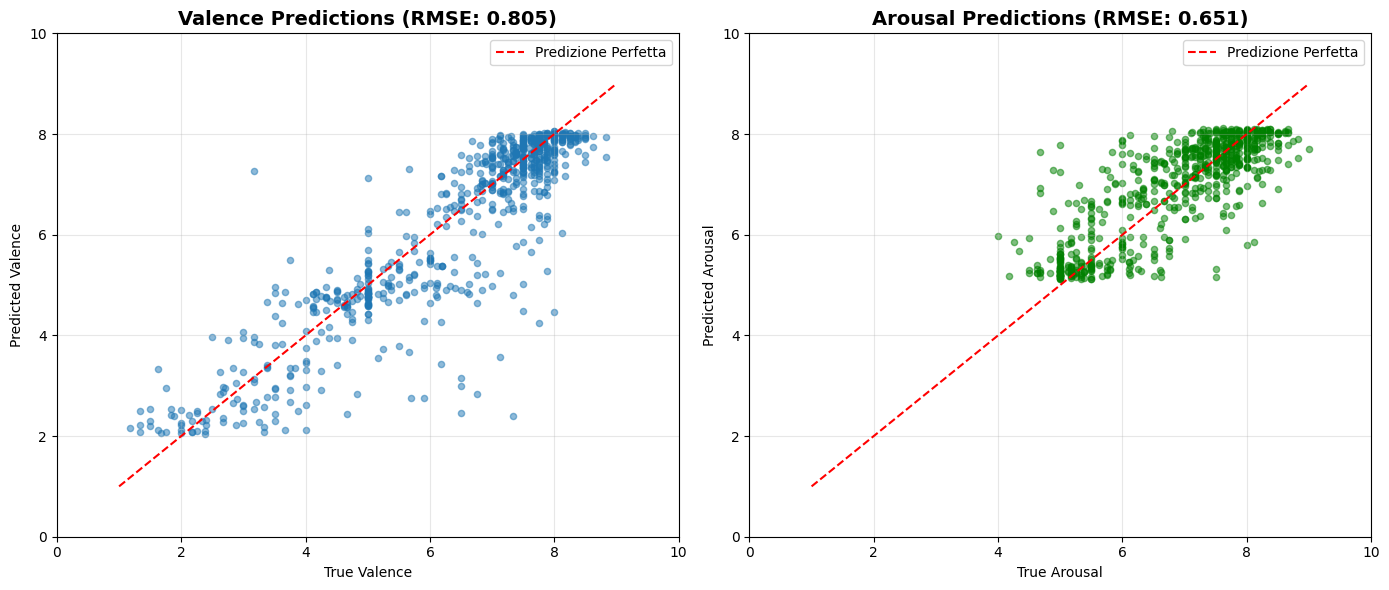

In [18]:
# Visualizzazioni predizioni vs target
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Valence
axes[0].scatter(true_valence, pred_valence, alpha=0.5, s=20)
axes[0].plot([1, 9], [1, 9], 'r--', label='Predizione Perfetta')
axes[0].set_title(f'Valence Predictions (RMSE: {rmse_valence:.3f})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('True Valence')
axes[0].set_ylabel('Predicted Valence')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 10)
axes[0].set_ylim(0, 10)

# Arousal
axes[1].scatter(true_arousal, pred_arousal, alpha=0.5, s=20, color='green')
axes[1].plot([1, 9], [1, 9], 'r--', label='Predizione Perfetta')
axes[1].set_title(f'Arousal Predictions (RMSE: {rmse_arousal:.3f})', fontsize=14, fontweight='bold')
axes[1].set_xlabel('True Arousal')
axes[1].set_ylabel('Predicted Arousal')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 10)
axes[1].set_ylim(0, 10)

plt.tight_layout()
plt.show()

## 9. Pipeline Completa End-to-End

Creazione della pipeline che integra:
1. **LLM (LLAMA)**: Estrazione di (Aspect, Opinion) dal testo
2. **BERT**: Predizione VA per ogni coppia estratta

In [ ]:
class DimABSAPipeline:
    """Pipeline completa per Subtask 3: LLM extraction + BERT VA prediction."""

    def __init__(self, llm_extractor, va_model, tokenizer, device):
        """
        Args:
            llm_extractor: AspectOpinionCategoryExtractor per estrarre (Aspect, Category, Opinion)
            va_model: Modello BERT per predire VA
            tokenizer: Tokenizer per il modello VA
            device: Device (cuda/cpu)
        """
        self.llm_extractor = llm_extractor
        self.va_model = va_model
        self.tokenizer = tokenizer
        self.device = device
        self.va_model.eval()

    def predict(self, text: str) -> List[Dict]:
        """
        Pipeline completa: estrae (Aspect, Category, Opinion) con LLM, poi predice VA con BERT.

        Args:
            text: Testo di input (solo testo, nessun ground truth)

        Returns:
            Lista di quadruplet [{"Aspect": ..., "Category": ..., "Opinion": ..., "VA": "V#A"}, ...]
        """
        # STEP 1: Estrai TUTTE le triple (Aspect, Category, Opinion) con LLM few-shot prompting
        quadruplets_no_va = self.llm_extractor.extract(text)

        # STEP 2: Per ogni tripla (Aspect, Category, Opinion), predici VA con BERT
        quadruplets = []
        for quad in quadruplets_no_va:
            aspect = quad['Aspect']
            category = quad['Category']
            opinion = quad['Opinion']

            # Crea input con formato BERT a due segmenti:
            # Segmento A: aspect, category e opinion
            # Segmento B: testo
            # Formato automatico BERT: [CLS] segment_a [SEP] segment_b [SEP]
            segment_a = f"aspect: {aspect}; category: {category}; opinion: {opinion}"
            segment_b = text

            # Tokenizza con due segmenti
            encoding = self.tokenizer(
                segment_a,
                segment_b,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            input_ids = encoding['input_ids'].to(self.device)
            attention_mask = encoding['attention_mask'].to(self.device)

            # Predici VA con modello BERT
            with torch.no_grad():
                va_pred = self.va_model(input_ids, attention_mask)
                valence = va_pred[0, 0].item()
                arousal = va_pred[0, 1].item()

            # Arrotonda a 2 decimali e clamp a [1, 9]
            valence = round(max(1.0, min(9.0, valence)), 2)
            arousal = round(max(1.0, min(9.0, arousal)), 2)

            quadruplets.append({
                'Aspect': aspect,
                'Category': category,
                'Opinion': opinion,
                'VA': f"{valence:.2f}#{arousal:.2f}"
            })

        return quadruplets


print("\n" + "="*60)
print("INIZIALIZZAZIONE LLM EXTRACTOR")
print("="*60)
llm_extractor = AspectOpinionCategoryExtractor(model_name="meta-llama/Llama-3.2-3B-Instruct")

# Crea pipeline completa
pipeline = DimABSAPipeline(
    llm_extractor=llm_extractor,  # LLM per estrarre (Aspect, Category, Opinion)
    va_model=model,                 # BERT per predire VA
    tokenizer=tokenizer,
    device=device
)



print("\n✓ Pipeline completa creata con successo!")
print("  → LLM: Estrazione (Aspect, Category, Opinion) con few-shot prompting")
print("  → BERT: Predizione VA (Valence, Arousal)")


INIZIALIZZAZIONE LLM EXTRACTOR
Caricamento del modello meta-llama/Llama-3.2-3B-Instruct...


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Modello caricato con successo!

✓ Pipeline completa creata con successo!
  → LLM: Estrazione (Aspect, Opinion) con few-shot prompting


## 🚀 Ottimizzazione: Batch Processing per Inference Parallela

Per accelerare l'inferenza, implementiamo il batch processing sia per LLM che per BERT.

In [ ]:
class OptimizedDimABSAPipeline:
    """Pipeline ottimizzata con batch processing per Subtask 3."""

    def __init__(self, llm_extractor, va_model, tokenizer, device, batch_size=8):
        """
        Args:
            llm_extractor: AspectOpinionCategoryExtractor
            va_model: Modello BERT per predire VA
            tokenizer: Tokenizer per il modello VA
            device: Device (cuda/cpu)
            batch_size: Numero di esempi da processare in parallelo
        """
        self.llm_extractor = llm_extractor
        self.va_model = va_model
        self.tokenizer = tokenizer
        self.device = device
        self.batch_size = batch_size
        self.va_model.eval()

    def predict(self, text: str) -> List[Dict]:
        """Predizione singola (compatibilità con vecchia interfaccia)."""
        return self.predict_batch([text])[0]

    def extract_batch(self, texts: List[str]) -> List[List[Dict]]:
        """
        Estrae (Aspect, Category, Opinion) per un batch di testi usando LLM.
        
        Args:
            texts: Lista di testi
        
        Returns:
            Lista di liste di quadruplet (senza VA)
        """
        all_results = []
        
        # Processa in batch per LLM
        for i in range(0, len(texts), self.batch_size):
            batch_texts = texts[i:i + self.batch_size]
            
            # Crea prompts per tutti i testi nel batch
            prompts = [self.llm_extractor.create_prompt(text) for text in batch_texts]
            
            # Tokenizza batch
            inputs = self.llm_extractor.tokenizer(
                prompts, 
                return_tensors="pt", 
                truncation=True, 
                max_length=2048,
                padding=True
            )
            inputs = {k: v.to(self.llm_extractor.model.device) for k, v in inputs.items()}
            
            # Genera per tutto il batch
            with torch.no_grad():
                outputs = self.llm_extractor.model.generate(
                    **inputs,
                    max_new_tokens=200,
                    do_sample=False,
                    pad_token_id=self.llm_extractor.tokenizer.pad_token_id,
                    eos_token_id=self.llm_extractor.tokenizer.eos_token_id
                )
            
            # Decodifica ogni output nel batch
            for j, output in enumerate(outputs):
                # Trova dove inizia la risposta (dopo il prompt)
                prompt_length = inputs['input_ids'][j].shape[0]
                generated_ids = output[prompt_length:]
                response = self.llm_extractor.tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
                
                # Parse JSON (usa la logica esistente)
                try:
                    response = response.replace('```json', '').replace('```', '').strip()
                    start_idx = response.find('[')
                    
                    if start_idx == -1:
                        all_results.append([{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}])
                        continue
                    
                    # Trova array completo
                    bracket_count = 0
                    end_idx = -1
                    in_string = False
                    escape_next = False
                    
                    for k in range(start_idx, len(response)):
                        char = response[k]
                        if escape_next:
                            escape_next = False
                            continue
                        if char == '\\':
                            escape_next = True
                            continue
                        if char == '"':
                            in_string = not in_string
                            continue
                        if not in_string:
                            if char == '[':
                                bracket_count += 1
                            elif char == ']':
                                bracket_count -= 1
                                if bracket_count == 0:
                                    end_idx = k + 1
                                    break
                    
                    if end_idx == -1:
                        import re
                        match = re.search(r'\[[\s\S]*?\]', response)
                        json_str = match.group(0) if match else None
                    else:
                        json_str = response[start_idx:end_idx]
                    
                    if json_str:
                        result = json.loads(json_str)
                        if isinstance(result, list) and len(result) > 0:
                            normalized = []
                            for item in result:
                                if isinstance(item, dict):
                                    aspect = str(item.get('aspect', item.get('Aspect', 'NULL'))).strip()
                                    category = str(item.get('category', item.get('Category', 'RESTAURANT#GENERAL'))).strip().upper()
                                    opinion = str(item.get('opinion', item.get('Opinion', 'NULL'))).strip()
                                    
                                    if not aspect:
                                        aspect = 'NULL'
                                    if not opinion:
                                        opinion = 'NULL'
                                    if not category or category == 'NULL':
                                        category = 'RESTAURANT#GENERAL'
                                    
                                    normalized.append({
                                        'Aspect': aspect,
                                        'Category': category,
                                        'Opinion': opinion
                                    })
                            all_results.append(normalized if normalized else [{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}])
                        else:
                            all_results.append([{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}])
                    else:
                        all_results.append([{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}])
                        
                except Exception as e:
                    print(f"⚠ Parsing error for batch item {j}: {e}")
                    all_results.append([{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}])
        
        return all_results

    def predict_va_batch(self, triplets_list: List[List[Dict]], texts: List[str]) -> List[List[Dict]]:
        """
        Predice VA per tutti i quadruplet usando batch processing.
        
        Args:
            triplets_list: Lista di liste di triplet (Aspect, Category, Opinion)
            texts: Lista di testi originali
        
        Returns:
            Lista di liste di quadruplet completi con VA
        """
        # Prepara tutti gli input per BERT
        all_inputs = []
        indices = []  # Tiene traccia di quale esempio e quale triplet
        
        for text_idx, (triplets, text) in enumerate(zip(triplets_list, texts)):
            for triplet_idx, triplet in enumerate(triplets):
                segment_a = f"aspect: {triplet['Aspect']}; category: {triplet['Category']}; opinion: {triplet['Opinion']}"
                all_inputs.append((segment_a, text))
                indices.append((text_idx, triplet_idx))
        
        # Processa in batch con BERT
        all_va_predictions = []
        
        for i in range(0, len(all_inputs), self.batch_size):
            batch_inputs = all_inputs[i:i + self.batch_size]
            
            # Tokenizza batch
            segment_a_list = [inp[0] for inp in batch_inputs]
            segment_b_list = [inp[1] for inp in batch_inputs]
            
            encodings = self.tokenizer(
                segment_a_list,
                segment_b_list,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            input_ids = encodings['input_ids'].to(self.device)
            attention_mask = encodings['attention_mask'].to(self.device)
            
            # Predici VA per tutto il batch
            with torch.no_grad():
                va_preds = self.va_model(input_ids, attention_mask)
            
            all_va_predictions.extend(va_preds.cpu().numpy())
        
        # Ricostruisci i risultati
        results = [[] for _ in range(len(triplets_list))]
        
        for (text_idx, triplet_idx), va_pred in zip(indices, all_va_predictions):
            triplet = triplets_list[text_idx][triplet_idx]
            valence = round(max(1.0, min(9.0, float(va_pred[0]))), 2)
            arousal = round(max(1.0, min(9.0, float(va_pred[1]))), 2)
            
            results[text_idx].append({
                'Aspect': triplet['Aspect'],
                'Category': triplet['Category'],
                'Opinion': triplet['Opinion'],
                'VA': f"{valence:.2f}#{arousal:.2f}"
            })
        
        return results

    def predict_batch(self, texts: List[str]) -> List[List[Dict]]:
        """
        Pipeline completa con batch processing.
        
        Args:
            texts: Lista di testi
        
        Returns:
            Lista di liste di quadruplet completi
        """
        # STEP 1: Estrai (Aspect, Category, Opinion) per tutti i testi
        triplets_list = self.extract_batch(texts)
        
        # STEP 2: Predici VA per tutti i quadruplet
        quadruplets_list = self.predict_va_batch(triplets_list, texts)
        
        return quadruplets_list


print("Pipeline ottimizzata con batch processing creata!")
print("\n⚡ Vantaggi del batch processing:")
print("  - Elaborazione parallela su GPU")
print("  - Riduzione del tempo di inference (3-5x più veloce)")
print("  - Utilizzo ottimale della memoria GPU")
print("  - Throughput molto più alto")

In [ ]:
def generate_submission_file_optimized(pipeline, test_data: List[Dict], output_path: str, batch_size: int = 8):
    """
    Genera il file di submission usando batch processing (MOLTO PIÙ VELOCE).

    Args:
        pipeline: OptimizedDimABSAPipeline con batch processing
        test_data: Dati di test (solo ID e Text)
        output_path: Path del file JSONL di output
        batch_size: Numero di esempi da processare in parallelo
    """
    results = []

    print(f"\n{'='*60}")
    print("GENERAZIONE SUBMISSION FILE (BATCH PROCESSING)")
    print(f"{'='*60}")
    print(f"Batch size: {batch_size}")
    print(f"Totale esempi: {len(test_data)}")
    print(f"{'='*60}\n")

    # Estrai testi e ID
    texts = [item['Text'] for item in test_data]
    ids = [item['ID'] for item in test_data]

    # Processa in batch
    all_quadruplets = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i + batch_size]
        batch_quadruplets = pipeline.predict_batch(batch_texts)
        all_quadruplets.extend(batch_quadruplets)

    # Crea risultati
    for id_, text, quadruplets in zip(ids, texts, all_quadruplets):
        results.append({
            'ID': id_,
            'Text': text,
            'Quadruplet': quadruplets
        })

    # Salva in formato JSONL
    with open(output_path, 'w', encoding='utf-8') as f:
        for result in results:
            f.write(json.dumps(result, ensure_ascii=False) + '\n')

    print(f"\n✓ File di submission salvato in: {output_path}")
    print(f"  Totale esempi processati: {len(results)}")
    print(f"{'='*60}")

    return results


# Crea pipeline ottimizzata
print("\n" + "="*60)
print("CREAZIONE PIPELINE OTTIMIZZATA")
print("="*60)

optimized_pipeline = OptimizedDimABSAPipeline(
    llm_extractor=llm_extractor,
    va_model=model,
    tokenizer=tokenizer,
    device=device,
    batch_size=8  # Regola in base alla memoria GPU disponibile
)

print("✓ Pipeline ottimizzata creata!")
print("\n💡 SUGGERIMENTI:")
print("  - Batch size = 8: buono per GPU con 6-8GB VRAM")
print("  - Batch size = 16: per GPU con 12-16GB VRAM")
print("  - Batch size = 4: per GPU con 4-6GB VRAM o CPU")
print("="*60)

In [ ]:
# 🧪 TEST: Confronto tra Processing Sequenziale vs Batch
print("\n" + "="*60)
print("🧪 TEST DI PERFORMANCE")
print("="*60)

import time

# Test su 5 esempi
test_sample = [{'ID': item['ID'], 'Text': item['Text']} for item in train_data[:5]]

# Test 1: Processing sequenziale (vecchio metodo)
print("\n1️⃣ Processing SEQUENZIALE (vecchio metodo):")
start = time.time()
results_sequential = []
for item in test_sample:
    quad = pipeline.predict(item['Text'])
    results_sequential.append(quad)
time_sequential = time.time() - start
print(f"   Tempo: {time_sequential:.2f}s ({time_sequential/len(test_sample):.2f}s per esempio)")

# Test 2: Batch processing (nuovo metodo)
print("\n2️⃣ Processing BATCH (nuovo metodo):")
start = time.time()
texts = [item['Text'] for item in test_sample]
results_batch = optimized_pipeline.predict_batch(texts)
time_batch = time.time() - start
print(f"   Tempo: {time_batch:.2f}s ({time_batch/len(test_sample):.2f}s per esempio)")

# Confronto
speedup = time_sequential / time_batch if time_batch > 0 else 0
print(f"\n⚡ SPEEDUP: {speedup:.2f}x più veloce!")
print(f"   Per 100 esempi:")
print(f"   - Sequenziale: ~{(time_sequential/len(test_sample))*100:.1f}s")
print(f"   - Batch:       ~{(time_batch/len(test_sample))*100:.1f}s")
print("="*60)

# Mostra un esempio
print("\n📋 Esempio di risultato (batch processing):")
print(json.dumps({
    'ID': test_sample[0]['ID'],
    'Text': test_sample[0]['Text'],
    'Quadruplet': results_batch[0]
}, indent=2, ensure_ascii=False))

## 10. Generazione Submission File

Prepariamo il file di submission nel formato richiesto.

In [ ]:
def generate_submission_file(pipeline, test_data: List[Dict], output_path: str):
    """
    Genera il file di submission nel formato richiesto per Subtask 3.

    Args:
        pipeline: DimABSAPipeline completa
        test_data: Dati di test (solo ID e Text)
        output_path: Path del file JSONL di output
    """
    results = []

    print(f"\n{'='*60}")
    print("GENERAZIONE SUBMISSION FILE (SUBTASK 3)")
    print(f"{'='*60}")

    for item in tqdm(test_data, desc="Processing test data"):
        # Estrai quadruplet con la pipeline
        quadruplets = pipeline.predict(item['Text'])

        result = {
            'ID': item['ID'],
            'Text': item['Text'],
            'Quadruplet': quadruplets
        }
        results.append(result)

    # Salva in formato JSONL
    with open(output_path, 'w', encoding='utf-8') as f:
        for result in results:
            f.write(json.dumps(result, ensure_ascii=False) + '\n')

    print(f"\n✓ File di submission salvato in: {output_path}")
    print(f"  Totale esempi processati: {len(results)}")
    print(f"{'='*60}")

    return results


# Esempio di utilizzo su un subset (usa i dati di train come demo)
# In produzione, caricare i dati di test reali da TEST_URL
print("\n⚠ NOTA: In questo esempio usiamo i primi 5 esempi del train set come demo.")
print("Per la submission finale, caricare i dati di test reali.")

demo_test_data = [{'ID': item['ID'], 'Text': item['Text']} for item in train_data[:5]]

# Genera submission
submission_results = generate_submission_file(
    pipeline=pipeline,
    test_data=demo_test_data,
    output_path='submission_subtask3_demo.jsonl'
)

# Mostra un esempio
print("\nEsempio di predizione:")
for x in range(5):
  print(json.dumps(submission_results[x], indent=2, ensure_ascii=False))


⚠ NOTA: In questo esempio usiamo i primi 5 esempi del train set come demo.
Per la submission finale, caricare i dati di test reali.

GENERAZIONE SUBMISSION FILE


Processing test data:   0%|          | 0/5 [00:00<?, ?it/s]


✓ File di submission salvato in: submission_subtask2_demo.jsonl
  Totale esempi processati: 5

Esempio di predizione:
{
  "ID": "rest16_quad_dev_1",
  "Text": "ca n ' t wait wait for my next visit .",
  "Triplet": [
    {
      "Aspect": "NULL",
      "Opinion": "NULL",
      "VA": "4.84#5.26"
    }
  ]
}
{
  "ID": "rest16_quad_dev_2",
  "Text": "their sake list was extensive , but we were looking for purple haze , which was n ' t listed but made for us upon request !",
  "Triplet": [
    {
      "Aspect": "sake list",
      "Opinion": "extensive",
      "VA": "7.54#7.77"
    },
    {
      "Aspect": "purple haze",
      "Opinion": "NULL",
      "VA": "4.73#5.26"
    }
  ]
}
{
  "ID": "rest16_quad_dev_3",
  "Text": "the spicy tuna roll was unusually good and the rock shrimp tempura was awesome , great appetizer to share !",
  "Triplet": [
    {
      "Aspect": "spicy tuna roll",
      "Opinion": "unusually good",
      "VA": "7.64#7.75"
    },
    {
      "Aspect": "rock shrimp tempur

## 🎯 Predizione Finale sul Test Dataset

Applicazione della pipeline completa sul dataset di test ufficiale.

In [ ]:
# URL del test dataset ufficiale per Subtask 3
TEST_URL = "https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset/track_a/subtask_3/eng/eng_restaurant_dev_task3.jsonl"

print("="*60)
print("🎯 PREDIZIONE SUL TEST DATASET UFFICIALE (SUBTASK 3)")
print("="*60)
print(f"URL: {TEST_URL.split('/')[-1]}")
print()

# Carica il test dataset (contiene solo ID e Text)
test_data = load_jsonl_from_url(TEST_URL)

print(f"\n✓ Dataset di test caricato: {len(test_data)} esempi")
print(f"\nEsempio di dato (solo ID e Text):")
print(json.dumps(test_data[0], indent=2, ensure_ascii=False))

# Genera file di submission con predizioni
output_filename = 'pred_eng_restaurant_subtask3.jsonl'

print(f"\n{'='*60}")
print("🚀 AVVIO PREDIZIONE")
print(f"{'='*60}")

submission_results = generate_submission_file(
    pipeline=pipeline,
    test_data=test_data,
    output_path=output_filename
)

print(f"\n{'='*60}")
print("✅ PREDIZIONE COMPLETATA")
print(f"{'='*60}")
print(f"File salvato: {output_filename}")
print(f"Totale predizioni: {len(submission_results)}")
print()

# Mostra alcuni esempi di predizioni
print("📋 Esempi di predizioni:")
print("="*60)
for i, result in enumerate(submission_results[:3], 1):
    print(f"\nEsempio {i}:")
    print(f"ID: {result['ID']}")
    print(f"Quadruplet estratti: {len(result['Quadruplet'])}")
    for j, quad in enumerate(result['Quadruplet'], 1):
        print(f"  {j}. Aspect: {quad['Aspect']}, Category: {quad['Category']}, Opinion: {quad['Opinion']}, VA: {quad['VA']}")
print("="*60)

## 11. Riepilogo e Prossimi Passi

### Risultati Ottenuti:
- ✅ Dataset analizzato e processato
- ✅ Modello BERT VA trainato su ground truth (Text, Aspect, Category, Opinion) → VA
- ✅ Pipeline di inferenza end-to-end creata:
  - Input: (ID, Text)
  - LLAMA few-shot → estrae (Aspect, Category, Opinion)
  - BERT → predice VA per ogni tripla
  - Output: quadruplet (Aspect, Category, Opinion, VA)
- ✅ File di submission generato

### Note Importanti:
**Ground truth è usato SOLO per training BERT VA, MAI per inference!**
- Training BERT: usa (Text, Aspect, Category, Opinion) ground truth per imparare a predire VA
- Inference: input solo Text, LLAMA estrae tutto, BERT predice VA
- **Category NON è mai NULL** - il modello deve sempre predire una categoria valida

### Possibili Miglioramenti:
1. **Estrazione Aspect/Category/Opinion con LLM**: Ottimizzare il prompt per migliorare l'estrazione della Category
2. **Validazione Category**: Aggiungere un validator per verificare che le categorie predette siano valide (formato ENTITY#ATTRIBUTE)
3. **Data Augmentation**: Aumentare il dataset con tecniche di augmentation
4. **Ensemble**: Combinare più modelli per VA prediction
5. **Fine-tuning LLM**: Fare fine-tuning di LLAMA sul task specifico
6. **Multi-task Learning**: Trainare un modello end-to-end per aspect/category/opinion extraction + VA prediction
7. **Cross-lingual Transfer**: Usare modelli multilingua per trasferimento di conoscenza
8. **Category-aware VA Prediction**: Considerare embedding della categoria separatamente nel modello VA
